### Various factors as predictors for diabetes

Joseph Gao, Kirsten Husdal, Tony Lee and Irene Wan

### Introduction

Diabetes is a chronic condition characterized by the dysregulation of blood glucose due to abnormal insulin levels. (World Health Organization, 2022). There are two etiologies for diabetes: Type 1, an autoimmune disorder, occurs when the pancreas has reduced insulin production, whereas Type 2 is a result of decreased insulin sensitivity (Diabetes Canada, 2022). Accounting for 95% of all current diagnoses, Type 2 diabetes develops in adulthood and is comorbid with factors such as high blood pressure, high BMI and family history (Diabetes Canada, 2022). This project will explore the correlations between diabetes, and comorbid factors in an effort to produce a diagnostic tool. 

diabetes.csv contains a subset of observations collected from a larger database generated by the National Institute of Diabetes and Digestive and Kidney Diseases. The data was collected from 2016 to 2022, with all participants being females of Pima Indian heritage over 21 years of age (Khare, 2022).

The dataset has the following variables:

* `Pregnancies` – number of pregnancies
* `Glucose` – blood glucose level (mg/dL)
* `BloodPressure` – diastolic blood pressure (mm/Hg)
* `SkinThickness` – triceps skinfold thickness (mm)
* `Insulin` – insulin level in the blood (IU/mL)
* `BMI` – body mass index (kg/m2)
* `DiabetesPedigreeFunction` – likelihood of diabetes based on family history
* `Age`
* `Outcome` – whether or not the individual has diabetes (1 = yes, 0 = no)


We will investigate if it is possible to predict the outcome (if an individual has diabetes or not) given the other variables in the dataset.


In [1]:
# Load libraries
library(tidyverse)
library(tidymodels)
library(ggplot2)

# Limiting visible table rows
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

After examining the data, there are no rows that require cleaning. However, there are values where zero was applied as a placeholder when the value was not collected. These zeroes are found in Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction and Age. To prevent them from influencing final calculations, these values will be filtered out. 

In [1]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
# Load libraries
library(tidyverse)
library(tidymodels)
library(ggplot2)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [27]:
#Filtering data

diabete_data <- read_csv("data/diabetes.csv") |>
                mutate(Outcome = as_factor(Outcome)) |>
                filter(Glucose != 0) |> 
                filter(BloodPressure != 0) |> 
                filter(SkinThickness != 0) |> 
                filter(Insulin != 0) |> 
                filter(BMI != 0) |> 
                filter(Age != 0) |> 
                filter(DiabetesPedigreeFunction != 0)


print("Table 1. Diagnostic factors, demographic information and diagnosis of patients")

diabete_data

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1. Diagnostic factors, demographic information and diagnosis of patients"


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
3,78,50,32,88,31.0,0.248,26,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,88,58,26,16,28.4,0.766,22,0
10,101,76,48,180,32.9,0.171,63,0
5,121,72,23,112,26.2,0.245,30,0


In [26]:
set.seed(1)

obs_num_outcome <- diabete_data |>
                    group_by(Outcome) |>
                    summarize(num_obs = n())

print("Table 2. Diagnosis of patients")

obs_num_outcome

print("Outcome(1) = diagnosis, Outcome(2) = no diagnosis , num_obs = number of observations.")

[1] "Table 2. Diagnosis of patients"


Outcome,num_obs
<fct>,<int>
0,262
1,130


[1] "Outcome(1) = diagnosis, Outcome(2) = no diagnosis , num_obs = number of observations."


In [3]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
set.seed(2022)

obs_num_outcome <- diabete_data |>
                    group_by(Outcome) |>
                    summarize(num_obs = n())

obs_num_outcome

Outcome,num_obs
<fct>,<int>
0,262
1,130


In [29]:
set.seed(1)

diabete_split <- initial_split(diabete_data, prop = 0.75, strata = Outcome)
diabete_train <- training(diabete_split)
diabete_test <- testing(diabete_split)

diabete_split
diabete_train
diabete_test

means_predictors <- diabete_train |>
    select(-Outcome) |>
    map_df(mean)

means_predictors

<Training/Testing/Total>
<293/99/392>

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,89,66,23,94,28.1,0.167,21,0
1,103,30,38,83,43.3,0.183,33,0
13,145,82,19,110,22.2,0.245,57,0
1,103,80,11,82,19.4,0.491,22,0
1,101,50,15,36,24.2,0.526,26,0
7,150,66,42,342,34.7,0.718,42,0
0,100,88,60,110,46.8,0.962,31,0
0,105,64,41,142,41.5,0.173,22,0
2,141,58,34,128,25.4,0.699,24,0


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5,166,72,19,175,25.8,0.587,51,1
1,115,70,30,96,34.6,0.529,32,1
3,126,88,41,235,39.3,0.704,27,0
11,143,94,33,146,36.6,0.254,51,1
10,125,70,26,115,31.1,0.205,41,1
1,97,66,15,140,23.2,0.487,22,0
3,88,58,11,54,24.8,0.267,22,0
4,103,60,33,192,24.0,0.966,33,0
3,180,64,25,70,34.0,0.271,26,0


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.34471,120.6519,70.88055,29.04778,149.6416,33.04403,0.5107099,30.69283


<<<<<<< local


[1] "Table 3. An overview of training data"


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,89,66,23,94,28.1,0.167,21,0
1,103,30,38,83,43.3,0.183,33,0
13,145,82,19,110,22.2,0.245,57,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,187,70,22,200,36.4,0.408,36,1
0,181,88,44,510,43.3,0.222,26,1
1,128,88,39,110,36.5,1.057,37,1


[1] "Table 4. An overview of testing data"


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5,166,72,19,175,25.8,0.587,51,1
1,115,70,30,96,34.6,0.529,32,1
3,126,88,41,235,39.3,0.704,27,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,121,78,39,74,39.0,0.261,28,0
2,88,58,26,16,28.4,0.766,22,0
5,121,72,23,112,26.2,0.245,30,0


[1] "Table 5. Means collected from patient data"


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,89,66,23,94,28.1,0.167,21,0
3,126,88,41,235,39.3,0.704,27,0
1,97,66,15,140,23.2,0.487,22,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,120,80,37,150,42.3,0.785,48,1
3,187,70,22,200,36.4,0.408,36,1
1,128,88,39,110,36.5,1.057,37,1


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5,166,72,19,175,25.8,0.587,51,1
1,103,30,38,83,43.3,0.183,33,0
10,125,70,26,115,31.1,0.205,41,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,102,44,20,94,30.8,0.400,26,0
1,109,58,18,116,28.5,0.219,22,0
0,181,88,44,510,43.3,0.222,26,1


>>>>>>> remote


In [5]:
set.seed(2022)
diabete_vfold <- vfold_cv(diabete_train, v = 5, strata = Outcome)

In [6]:
knn_recipe <- recipe(Outcome ~ ., data = diabete_train) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

In [7]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

In [8]:
set.seed(2022)
knn_results <- workflow() |>
               add_recipe(knn_recipe) |>
               add_model(knn_spec) |>
               tune_grid(resamples = diabete_vfold, grid = 20) |>
               collect_metrics() |>
               filter(.metric == "accuracy") |>
               arrange(desc(mean))

knn_results

<<<<<<< local


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,binary,0.7512215,5,0.01774912,Preprocessor1_Model14
3,accuracy,binary,0.7477713,5,0.01911272,Preprocessor1_Model02
4,accuracy,binary,0.7477713,5,0.01911272,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
7,accuracy,binary,0.7270836,5,0.02325579,Preprocessor1_Model06
8,accuracy,binary,0.7270836,5,0.02325579,Preprocessor1_Model07
2,accuracy,binary,0.7067387,5,0.01926533,Preprocessor1_Model01


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.7748393,5,0.02824656,Preprocessor1_Model03
4,accuracy,binary,0.7748393,5,0.02824656,Preprocessor1_Model04
9,accuracy,binary,0.7675959,5,0.02963416,Preprocessor1_Model08
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,binary,0.7574245,5,0.02324299,Preprocessor1_Model11
1,accuracy,binary,0.7407598,5,0.02689972,Preprocessor1_Model01
2,accuracy,binary,0.7407598,5,0.02689972,Preprocessor1_Model02


>>>>>>> remote


<<<<<<< local


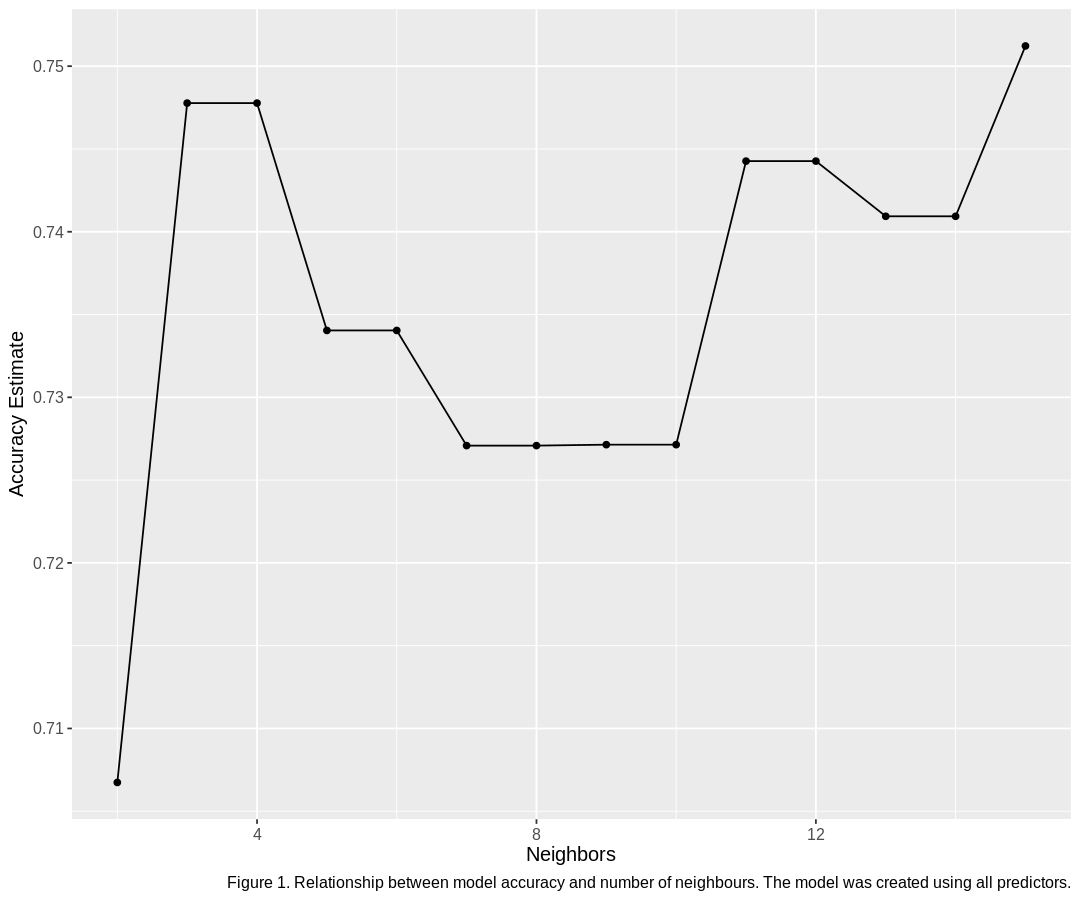

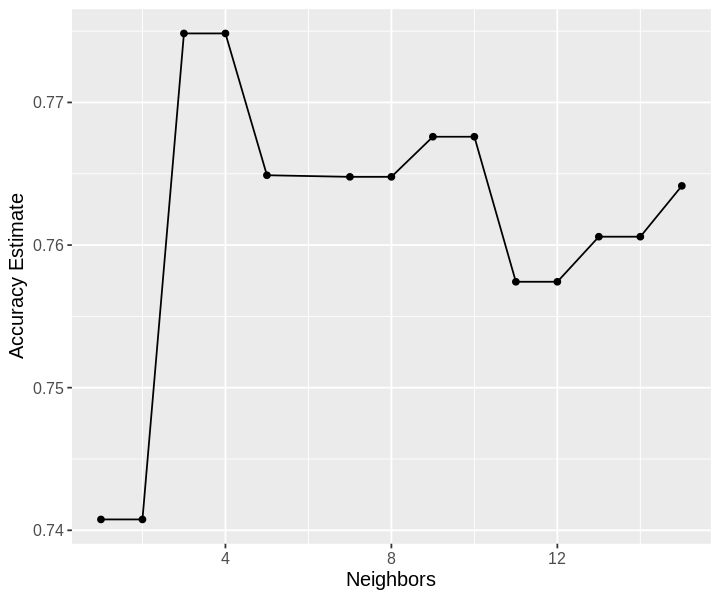

>>>>>>> remote


In [36]:
options(repr.plot.height = 7.5, repr.plot.width = 9)

cross_val_plot <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate", 
                         caption = "Figure 1. Relationship between model accuracy and number of neighbours. The model was created using all predictors.") +
                    theme(text = element_text(size = 12)) 

cross_val_plot

In [10]:
diabete_recipe <- recipe(Outcome ~., data = diabete_train)

diabete_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
               set_engine("kknn") |>
               set_mode("classification")

diabete_fit <- workflow() |>
             add_recipe(diabete_recipe) |>
             add_model(diabete_spec) |>
             fit(data = diabete_train)

diabete_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(15,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2320819
Best kernel: rectangular
Best k: 15

In [ ]:
set.seed(1) 

diabete_predictions <- predict(diabete_fit, diabete_test) |>
                    bind_cols(diabete_test)

diabete_predictions

<<<<<<< local


[1] "Table 6. Comparison of model diagnosis and original outcome"


.pred_class,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,5,166,72,19,175,25.8,0.587,51,1
0,1,115,70,30,96,34.6,0.529,32,1
0,3,126,88,41,235,39.3,0.704,27,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,1,121,78,39,74,39.0,0.261,28,0
0,2,88,58,26,16,28.4,0.766,22,0
0,5,121,72,23,112,26.2,0.245,30,0


[1] "pred.class = Predicted Diagnosis"


.pred_class,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5,166,72,19,175,25.8,0.587,51,1
0,1,103,30,38,83,43.3,0.183,33,0
0,10,125,70,26,115,31.1,0.205,41,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,3,102,44,20,94,30.8,0.400,26,0
0,1,109,58,18,116,28.5,0.219,22,0
1,0,181,88,44,510,43.3,0.222,26,1


>>>>>>> remote


In [ ]:
diabete_metrics <- diabete_predictions |> 
                metrics(truth = Outcome, estimate = .pred_class) |>
                filter(.metric == "accuracy")

print("Table 7. Model degree of accuracy")
diabete_metrics
print(".metric = statistic measured, .estimator = measurement type, .estimate = degree of metric")

<<<<<<< local


[1] "Table 7. Model degree of accuracy"


>>>>>>> remote
<<<<<<< local <unchanged>


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8080808


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7777778


>>>>>>> remote <modified: text/html, text/latex, text/markdown, text/plain>


[1] ".metric = statistic measured, .estimator = measurement type, .estimate = degree of metric"


In [ ]:
mnist_conf_mat <- diabete_predictions |>
                    conf_mat(truth = Outcome, estimate = .pred_class)

print("Figure 2. A signal detection matrix measuring hits, misses, false alarms and correct rejections.")
mnist_conf_mat

<<<<<<< local


[1] "Figure 2. A signal detection matrix measuring hits, misses, false alarms and correct rejections."


>>>>>>> remote
<<<<<<< local <unchanged>


          Truth
Prediction  0  1
         0 62 15
         1  4 18

          Truth
Prediction  0  1
         0 56 12
         1 10 21

>>>>>>> remote <modified: text/plain>


### Discussion

### References

Diabetes Canada. (2017). Diabetes Canada 2018 Pre-Budget Submission: 90-90-90 - Measurable change and improved productivity by 2021. Retrieved from Diabetes Canada: https://www.diabetes.ca/DiabetesCanadaWebsite/media/Advocacy-and-Policy/Submissions%20to%20Government/Federal/2018-Federal-PBS.pdf

Diabetes Canada. (2022). Assess your risk of developing diabetes. DiabetesCanadaWebsite. Retrieved October 27, 2022, from https://www.diabetes.ca/type-2-risks/risk-factors---assessments 

Diabetes Canada. (2022). What is diabetes? DiabetesCanadaWebsite. Retrieved October 27, 2022, from https://www.diabetes.ca/about-diabetes/what-is-diabetes 

Holman, R. R., Paul, S. K., Bethel, M. A., Matthews, D. R., & Neil, H. A. (2008). 10-year follow-up of intensive glucose control in type 2 diabetes. New England Journal of Medicine, 359(15), 1577–1589. https://doi.org/10.1056/nejmoa0806470 

Khare, A. D. (2022, April 8). Diabetes Dataset. Retrieved October 20, 2022, from https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset.
Version 1

Schneider, T., Gomes, T., Hayes, K. N., Suda, K. J., & Tadrous, M. (2022). Comparisons of insulin spending and price between Canada and the United States. Mayo Clinic Proceedings, 97(3), 573–578. https://doi.org/10.1016/j.mayocp.2021.11.028 

Spencer Bonilla, G., Rodriguez-Gutierrez, R., & Montori, V. M. (2016). What we don’t talk about when we talk about preventing type 2 diabetes—addressing socioeconomic disadvantage. JAMA Internal Medicine, 176(8), 1053. https://doi.org/10.1001/jamainternmed.2016.2952 

World Health Organization. (n.d.). Diabetes. World Health Organization. Retrieved October 27, 2022, from https://www.who.int/health-topics/diabetes#tab=tab_3 

World Health Organization. (2022, September 16). Diabetes. World Health Organization. Retrieved October 27, 2022, from https://www.who.int/news-room/fact-sheets/detail/diabetes 